# Pastas and Metran example

This notebook shows how output from Pastas timeseries models can be analyzed using Metran.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps
import metran

ps.logger.setLevel("ERROR")

## Read data

Load the observed heads from piezometers at different depths at location B21B0214. The outliers (values outside of $5 \sigma$ (std. dev.) are removed from the timeseries.

In [2]:
oseries = {}
ofiles = [os.path.join("./data", f) for f in os.listdir("./data") if f.endswith("_1.csv")]

for fi in ofiles:
    name = fi.split(os.sep)[-1].split(".")[0].split("_")[0]
    o = ps.read_dino(fi)
    
    # remove outliers outside 5*std
    mean = o.series_original.median()
    std = o.series_original.std()
    mask_outliers = ((o.series_original - mean).abs() > 5*std)
    ts = o.series_original.copy()
    ts.loc[mask_outliers] = np.nan
    
    # create pastas.Timeseries
    o = ps.TimeSeries(ts, settings="oseries", metadata=o.metadata)
    
    # store timeseries
    oseries[name] = o

In [3]:
# sort the names
sorted_names = list(oseries.keys())
sorted_names.sort()
sorted_names

['B21B0214001', 'B21B0214002', 'B21B0214003', 'B21B0214004', 'B21B0214005']

Plot the heads:

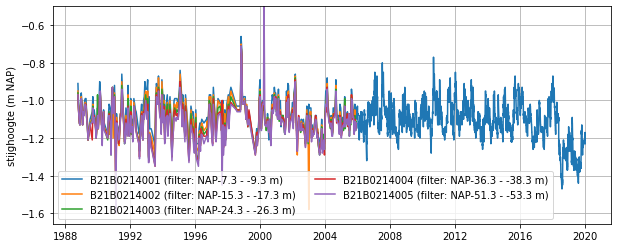

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for name in sorted_names:
    o = oseries[name]
    ftop = float(o.metadata["Bovenkant filter (cm t.o.v. NAP)"]) / 100.
    fbot = float(o.metadata["Onderkant filter (cm t.o.v. NAP)"]) / 100.
    lbl = f"{name} (filter: NAP{ftop:+.1f} - {fbot:+.1f} m)"
    ax.plot(o.series_original.index, o.series_original, label=lbl)

ax.set_ylabel("stijghoogte (m NAP)")
ax.legend(loc='best', ncol=2)
ax.set_ylim(top=-0.5)
ax.grid(b=True)

Load the precipitation and evaporation data from two nearby weather stations

In [5]:
p = pd.read_csv("./data/RD_338.csv", index_col=[0], parse_dates=True, usecols=["YYYYMMDD", "RD"])
e = pd.read_csv("./data/EV24_260.csv", index_col=[0], parse_dates=True, usecols=["YYYYMMDD", "EV24"])

Plot precipitation and evaporation timeseries

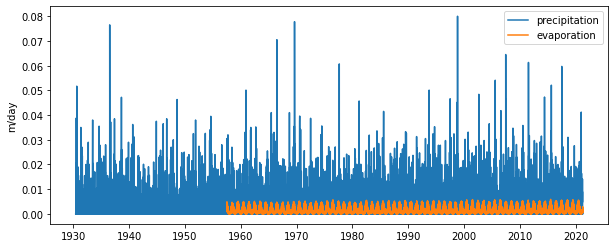

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(p.index, p, label="precipitation")
ax.plot(e.index, e, label="evaporation")
ax.set_ylabel("m/day")
ax.legend(loc="best");

## Build timeseries models

Build timeseries models. The timeseries models attempt to simulate the heads using recharge as stress. The recharge is calculated using $R  = P - f \cdot E$, where $R$ is recharge, $P$ is precipitation, $E$ is evaporation and $f$ is factor that is optimized. The model fit results are printed to to the console. The model residuals are stored for analysis with Metran.

In [7]:
# Normalize the index (reset observation time to midnight (the end of the day)).
p.index = p.index.normalize()
e.index = e.index.normalize()

# set tmin/tmax
tmin = "1988-10-14"
tmax = "2005-11-28"

# store models and residuals
models = []
residuals = []

for name in sorted_names:
    # create model
    ml = ps.Model(oseries[name])
    rm = ps.RechargeModel(prec=p, evap=e)
    ml.add_stressmodel(rm)
    
    # solve model
    ml.solve(tmin=tmin, tmax=tmax, report=False)
    
    # print fit statistic
    print(name, f"EVP = {ml.stats.evp():.1f}%")
    
    # store model
    models.append(ml)
    
    # get residuals
    r = ml.residuals()
    r.name = name
    residuals.append(r)

B21B0214001 EVP = 68.4%
B21B0214002 EVP = 58.9%
B21B0214003 EVP = 66.8%
B21B0214004 EVP = 61.3%
B21B0214005 EVP = 51.0%


## Build Metran model

A Metran model is created using the residuals of the timeseries models. By analyzing the model residuals we can determine for example, whether there is a common pattern in the residuals, which could indicate a missing influence, or a shortcoming in the model structure. Additionally we might also be able to analyze whether there are still outliers left in our timeseries.

In [8]:
mt = metran.Metran(residuals)
mt.solve()    

INFO: Number of factors according to Velicer's MAP test: 1



Fit report Cluster             Fit Statistics
tmin     None             obj     3159.54
tmax     None             nfev     77
freq     D                AIC     3171.54
solver   ScipySolve                  

Parameters (6 were optimized)
            optimal         stderr initial  vary
sdf1_alpha   7.9163        ±12.84%      10  True
sdf2_alpha  5.94076        ±17.03%      10  True
sdf3_alpha  2.81207        ±38.09%      10  True
sdf4_alpha    1e-05  ±23338370.42%      10  True
sdf5_alpha   8.9661        ±11.69%      10  True
cdf1_alpha  14.5001         ±9.55%      10  True

Parameter correlations |rho| > 0.5
None

Metran report Cluster        Factor Analysis
tmin     None                nfct    1
tmax     None                fep     81.32%
freq     D                            

Communality
                   
B21B0214001  84.36%
B21B0214002  67.77%
B21B0214003  88.55%
B21B0214004  90.71%
B21B0214005  63.38%

State parameters
                  phi         q
sdf1         0.881331  0.03

Plot the specific and common dynamic components

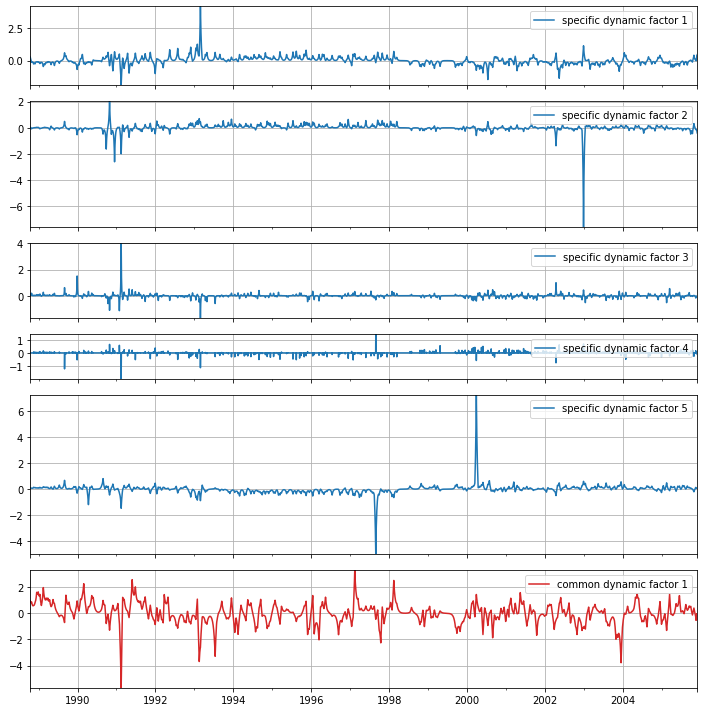

In [9]:
axes = mt.plots.state_means()

Plot a simulation, including a confidence interval for B21B0214003.

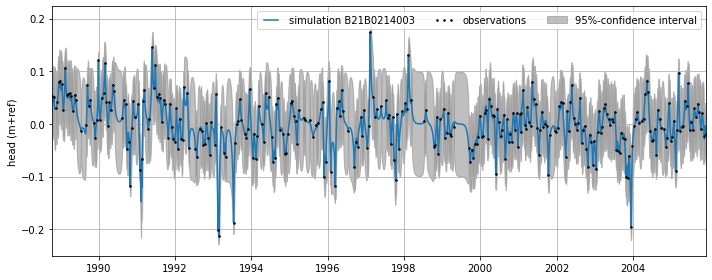

In [10]:
ax = mt.plots.simulation(sorted_names[2])